In [ ]:
!git clone https://github.com/Negatix092/DM1.git

# 1. Dado el conjunto de datos “dog & cats” con 25k y 12.5k imágenes (gatos y perros) de training and test, el cual se puede descargar aquí dogs-vs-cats.zip). Se desea:

* Aplicar la tarea de normalización a los datos para que cumplan con los requerimientos de entrada de los modelos de clasificación. Se sugiere hacer un resize(image) para la dimensión más pequeña entre ambos conjuntos.

In [1]:
train_folder = '/content/DM1/CNN/dogs-vs-cats/train'
test_folder = '/content/DM1/CNN/dogs-vs-cats/test1'

## General

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from concurrent.futures import ThreadPoolExecutor

apply_canny = True  # Ajustar a False si no quieres usar la detección de bordes

# Función para contar imágenes en una carpeta
def count_images_in_folder(folder):
    try:
        count = len(os.listdir(folder))
        return count
    except FileNotFoundError:
        print(f"Error: La carpeta {folder} no se encontró.")
        return 0

# Función para cargar imágenes originales (sin ninguna transformación)
def load_original_images(folder):
    images = []
    img_paths = [os.path.join(folder, img_name) for img_name in os.listdir(folder)]

    for img_path in img_paths:
        img = cv2.imread(img_path)  # Cargar la imagen tal cual
        if img is not None:
            images.append(img)

    return images

# Función para cargar y preprocesar una imagen
def load_and_preprocess_single_image(img_path, apply_canny=False, for_naive_bayes=False):
    img = cv2.imread(img_path)

    if img is not None:
        original_size = img.shape[:2]  # Almacenar tamaño original
        if for_naive_bayes:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises para Naive Bayes

        img = cv2.resize(img, (64, 64))  # Redimensionar a 64x64

        if apply_canny:
          img = cv2.Canny(img, 100, 200)

        img = img / 255.0  # Normalizar los valores de los píxeles a un rango entre 0 y 1
        return img, original_size
    else:
        return None, None

# Función para cargar y preprocesar imágenes usando hilos
def load_and_preprocess_images_threaded(folder, apply_canny=False, for_naive_bayes=False):
    images = []
    original_sizes = []

    img_paths = [os.path.join(folder, img_name) for img_name in os.listdir(folder)]

    # Usar hilos para cargar y preprocesar imágenes en paralelo
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = executor.map(lambda path: load_and_preprocess_single_image(path, apply_canny, for_naive_bayes), img_paths)

    for img, original_size in results:
        if img is not None:
            images.append(img)
            original_sizes.append(original_size)

    return np.array(images), np.array(original_sizes)

# Preprocesamiento para ambos conjuntos (entrenamiento y prueba)
def preprocess_images_for_both_models(train_folder, test_folder, apply_canny=False, for_naive_bayes=False):
    # Cargar y preprocesar las imágenes de entrenamiento y prueba usando hilos
    train_images, train_original_sizes = load_and_preprocess_images_threaded(train_folder, apply_canny, for_naive_bayes)
    test_images, test_original_sizes = load_and_preprocess_images_threaded(test_folder, apply_canny, for_naive_bayes)

    return train_images, test_images, train_original_sizes, test_original_sizes

# Función para graficar comparativa de tamaños originales vs redimensionados
def plot_image_sizes(original_sizes, resized_shape):
    original_heights = [size[0] for size in original_sizes]
    original_widths = [size[1] for size in original_sizes]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(original_heights, bins=30, alpha=0.7, color='b', label='Original Heights')
    plt.hist(original_widths, bins=30, alpha=0.7, color='r', label='Original Widths')
    plt.title('Tamaños Originales')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.bar(['Resized Height', 'Resized Width'], [resized_shape[0], resized_shape[1]], color=['b', 'r'])
    plt.title(f'Tamaños Redimensionados ({resized_shape[0]}x{resized_shape[1]})')
    plt.show()

# Función para seleccionar una muestra de las imágenes
def sample_image_sizes(original_sizes, sample_fraction=0.05):
    sample_size = int(len(original_sizes) * sample_fraction)
    return random.sample(list(original_sizes), sample_size)

# Función para mostrar imágenes
def show_random_images(images, title, n=4):
    indices = random.sample(range(len(images)), n)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[idx], cmap='gray' if len(images[idx].shape) == 2 else None)
        plt.title(f"{title} - {i+1}")
        plt.axis('off')
    plt.show()

# Verificar el número de imágenes procesadas
def verify_image_count(train_folder, test_folder):
    print("Verificación de número de imágenes:")
    train_count = count_images_in_folder(train_folder)
    test_count = count_images_in_folder(test_folder)
    print(f"Total imágenes en entrenamiento: {train_count}")
    print(f"Total imágenes en test: {test_count}")  # Verificar número de imágenes en cada conjunto

In [4]:
train_images, test_images, train_original_sizes, test_original_sizes = preprocess_images_for_both_models(train_folder, test_folder, apply_canny)

### Visualización

#### Número de imágenes en cada conjunto

In [5]:
# Verificar número de imágenes en cada conjunto
verify_image_count(train_folder, test_folder)

Verificación de número de imágenes:
Total imágenes en entrenamiento: 25000
Total imágenes en test: 12500


#### Muestra imágenes originales

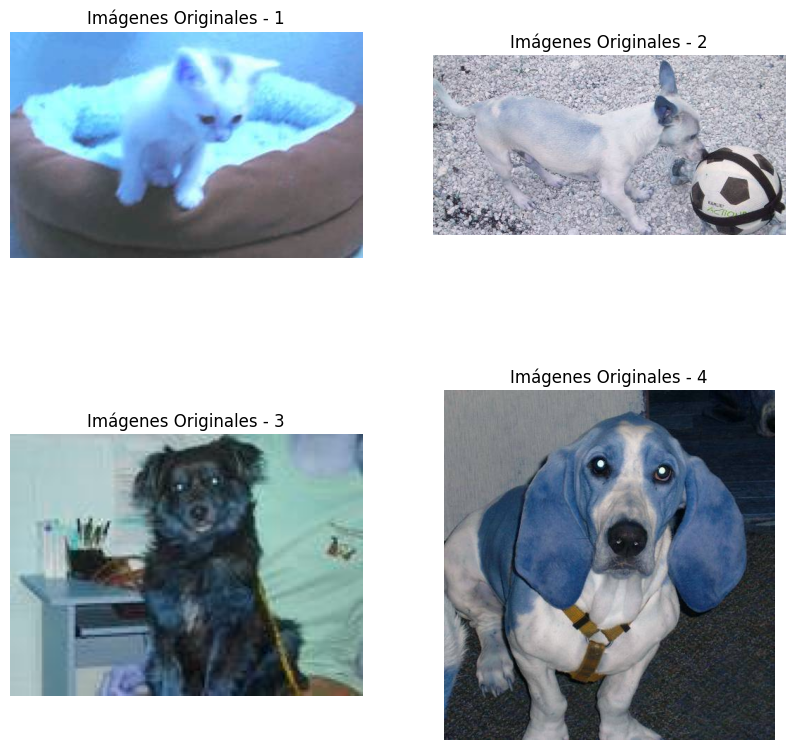

In [6]:
# Cargar imágenes originales tal como están
original_images = load_original_images(train_folder)

# Mostrar 4 imágenes originales
show_random_images(original_images, "Imágenes Originales")

#### Mostrar imágenes con Preprocesamiento General

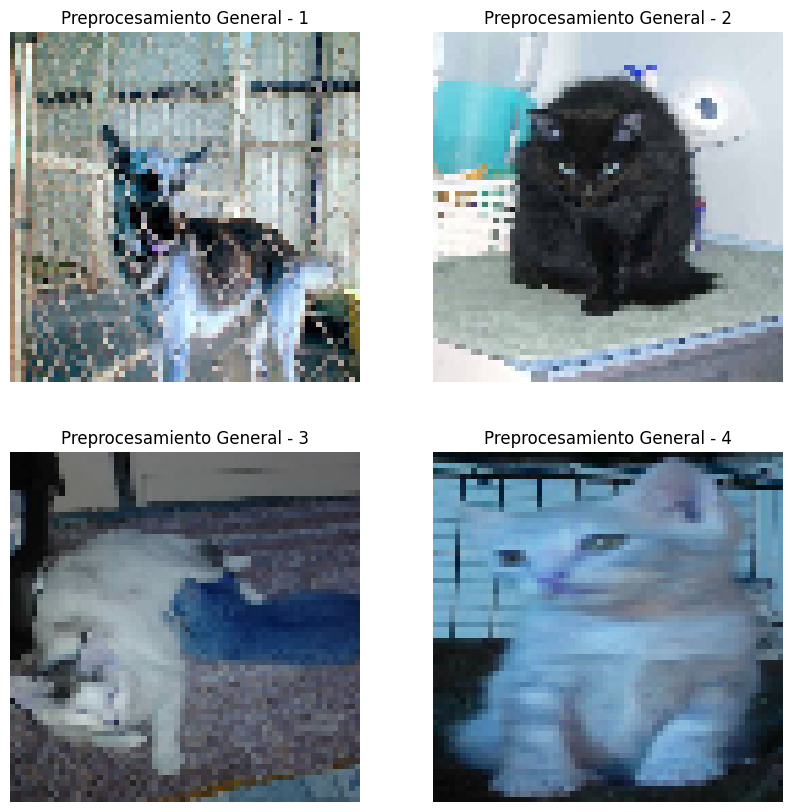

In [7]:
# Mostrar 4 imágenes con preprocesamiento básico (sin Canny y sin Naive Bayes)
train_images_general, _ = load_and_preprocess_images_threaded(train_folder, apply_canny=False, for_naive_bayes=False)
show_random_images(train_images_general, "Preprocesamiento General")

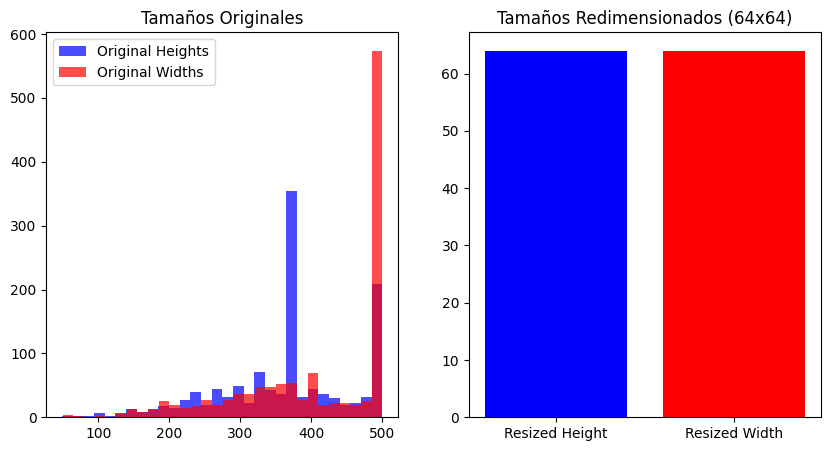

In [8]:
# Tomar una muestra del 5% de las imágenes y mostrar tamaños originales para General
sampled_train_sizes_general = sample_image_sizes(train_original_sizes, sample_fraction=0.05)
plot_image_sizes(sampled_train_sizes_general, (64, 64))

## Preprocesamiento Naive Bayes

In [18]:
import numpy as np
from skimage.feature import hog
import cv2
from sklearn.decomposition import PCA

# Aplanar las imágenes (necesario para Naive Bayes)
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

# Función para extraer características HOG
def hog_features(img, for_naive_bayes=False):
    if for_naive_bayes:
        # Si Naive Bayes, asegurarse de que la imagen esté en escala de grises
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        features = hog(img, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=False)
    else:
        # Para CNN o imágenes multicanal, manejar diferentes canales de imagen
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        features = hog(img, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=False)

    return features

# Función para aplicar pca
def preprocess_images_with_pca(train_nb, test_nb):
    pca = PCA(n_components=100)  # Adjust the number of components to explain enough variance
    train_nb_pca = pca.fit_transform(train_nb)
    test_nb_pca = pca.transform(test_nb)
    return train_nb_pca, test_nb_pca

# Función para aplicar HOG a todas las imágenes de un conjunto
def preprocess_naive_bayes(train_images):
    hog_train = [hog_features(img, for_naive_bayes=True) for img in train_images]
    return np.array(hog_train)

# Para Naive Bayes, preprocesar en escala de grises sin detección de bordes
train_images_naive_bayes, test_images_naive_bayes, train_original_sizes_naive_bayes, test_original_sizes_naive_bayes = preprocess_images_for_both_models(train_folder, test_folder, apply_canny=False, for_naive_bayes=True)

# Aplanar las imágenes para Naive Bayes
train_images_naive_bayes_flat = flatten_images(train_images_naive_bayes)
test_images_naive_bayes_flat = flatten_images(test_images_naive_bayes)

# Extraer características HOG para Naive Bayes
train_images_naive_bayes_HOG= preprocess_naive_bayes(train_images_naive_bayes)
test_images_naive_bayes_HOG = preprocess_naive_bayes(test_images_naive_bayes)

# Aplicar PCA
train_nb, test_nb = preprocess_images_with_pca(train_images_naive_bayes_HOG, test_images_naive_bayes_HOG)

### Visualización

In [10]:
# Mostrar las dimensiones de las imagenes aplanadas
print(f"Imágenes aplanadas para Naive Bayes - Train: {train_images_naive_bayes_flat.shape}")
print(f"Imágenes aplanadas para Naive Bayes - Test: {test_images_naive_bayes_flat.shape}")

# Mostrar las dimensiones después de aplicar HOG
print(f"Imágenes preprocesadas para Naive Bayes (HOG) - Train: {train_images_naive_bayes_HOG.shape}")
print(f"Imágenes preprocesadas para Naive Bayes (HOG) - Test: {test_images_naive_bayes_HOG.shape}")

# Mostrar las dimensiones después de aplicar PCA
print(f"Imágenes preprocesadas para Naive Bayes (PCA) - Train: {train_nb.shape}")
print(f"Imágenes preprocesadas para Naive Bayes (PCA) - Test: {test_nb.shape}")

Imágenes aplanadas para Naive Bayes - Train: (25000, 4096)
Imágenes aplanadas para Naive Bayes - Test: (12500, 4096)
Imágenes preprocesadas para Naive Bayes (HOG) - Train: (25000, 1764)
Imágenes preprocesadas para Naive Bayes (HOG) - Test: (12500, 1764)
Imágenes preprocesadas para Naive Bayes (PCA) - Train: (25000, 100)
Imágenes preprocesadas para Naive Bayes (PCA) - Test: (12500, 100)


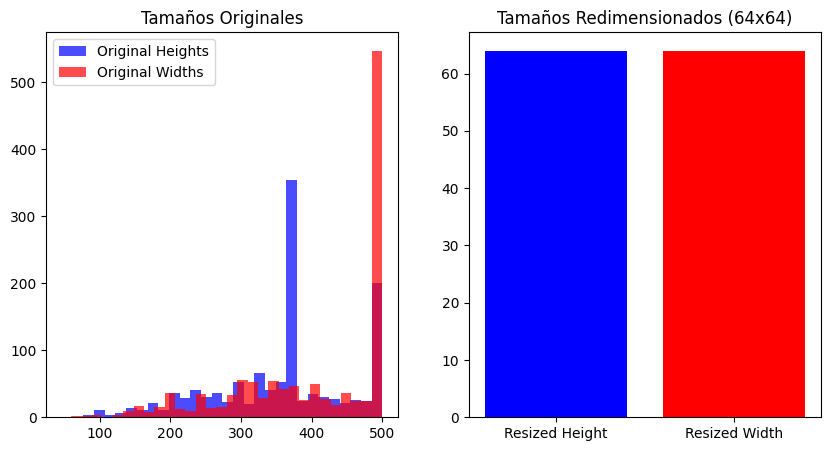

In [11]:
# Tomar una muestra del 5% de las imágenes y mostrar tamaños originales para Naive Bayes
sampled_train_sizes_nb = sample_image_sizes(train_original_sizes_naive_bayes, sample_fraction=0.05)
plot_image_sizes(sampled_train_sizes_nb, (64, 64))

## Preprocesamiento CNN

In [12]:
# Preprocesamiento específico para CNN
def preprocess_cnn(train_folder, test_folder, apply_canny=False):
    train_cnn, train_original_sizes_cnn = load_and_preprocess_images_threaded(train_folder, apply_canny=apply_canny, for_naive_bayes=False)
    test_cnn, test_original_sizes_cnn = load_and_preprocess_images_threaded(test_folder, apply_canny=apply_canny, for_naive_bayes=False)

    return train_cnn, test_cnn, train_original_sizes_cnn, test_original_sizes_cnn

### Visualización

In [13]:
train_cnn, test_cnn, train_original_sizes_cnn, test_original_sizes_cnn = preprocess_cnn(train_folder, test_folder, apply_canny=False)

# Mostrar las dimensiones de los conjuntos preprocesados
print(f"Conjunto de entrenamiento para CNN - Train: {train_cnn.shape}")
print(f"Conjunto de test para CNN - Test: {test_cnn.shape}")

Conjunto de entrenamiento para CNN - Train: (25000, 64, 64, 3)
Conjunto de test para CNN - Test: (12500, 64, 64, 3)


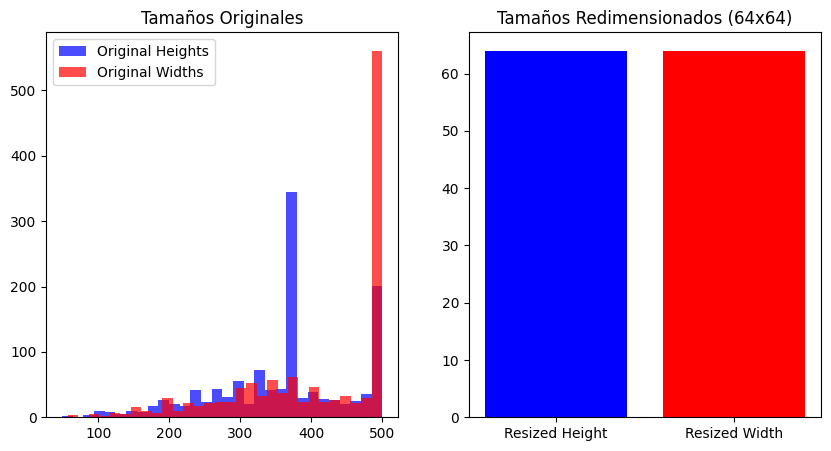

In [14]:
# Tomar una muestra del 5% de las imágenes y mostrar tamaños
sampled_train_sizes_cnn = sample_image_sizes(train_original_sizes_cnn, sample_fraction=0.05)
plot_image_sizes(sampled_train_sizes_cnn, (64, 64))

# Utilizar la técnica, stratified 10-fold cross-validation (CV) para mostrar los resultados a nivel de promedio y desviación estándar de cada métrica supervisada considerada para esta tarea (AUC, Precision, Recall, F1-score). Investigar la técnica k-fold Cross-Validation y las métricas solicitadas para aplicarla correctamente.

### Stratified 10-Fold CV usando NB

### Improved version (multinomialNB)

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, roc_auc_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
# Aplanar las imágenes para usar en Naive Bayes
# X_flat = train_images.reshape(train_images.shape[0], -1)

# Crear las etiquetas (1 para perro, 0 para gato)
y = np.array([1 if 'dog' in img else 0 for img in os.listdir(train_folder)])

# Escalar los valores para que estén en el rango [0, 1] para MultinomialNB
scaler = MinMaxScaler()
X_flat = scaler.fit_transform(train_nb)  # Normalizamos los datos entre 0 y 1

# Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_flat)

# Model
nb_model = MultinomialNB()

# Definir el Stratified K-Fold CV
skf = StratifiedKFold(n_splits=10)

# Listas para almacenar los resultados de cada métrica
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Cross-validation
for train_index, test_index in skf.split(X_poly, y):
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model
    nb_model.fit(X_train, y_train)

    # Predict
    y_pred = nb_model.predict(X_test)
    y_prob = nb_model.predict_proba(X_test)[:, 1]

    # Evaluate
    auc_scores.append(roc_auc_score(y_test, y_prob))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Mostrar los resultados promedio y desviación estándar
print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

AUC: 0.779 ± 0.009
Precision: 0.702 ± 0.009
Recall: 0.743 ± 0.009
F1-score: 0.722 ± 0.005


In [20]:
# Preprocesar el conjunto de test sin aplicar PCA (HOG + Polynomial Features)
# nos aseguramos de que el preprocesamiento sea consistente con el conjunto de entrenamiento.

# Aplicar Polynomial Features al conjunto de prueba
test_images_poly = poly.fit_transform(test_nb)

# Hacer las predicciones en el conjunto de test preprocesado (ahora con PCA y Polynomial Features)
test_predictions = nb_model.predict(test_images_poly)

# Convertir las predicciones (0 y 1) a etiquetas "cat" y "dog"
test_predictions_labels = ['cat' if pred == 0 else 'dog' for pred in test_predictions]

# Imprimir las etiquetas predichas para cada imagen del conjunto de prueba
for img_name, label in enumerate(zip(os.listdir(test_folder), test_predictions_labels)):
    print(f"Image: {img_name} -> Predicted: {label}")

Streaming output truncated to the last 5000 lines.
Image: 7500 -> Predicted: ('610.jpg', 'cat')
Image: 7501 -> Predicted: ('1381.jpg', 'cat')
Image: 7502 -> Predicted: ('708.jpg', 'dog')
Image: 7503 -> Predicted: ('3892.jpg', 'cat')
Image: 7504 -> Predicted: ('8657.jpg', 'dog')
Image: 7505 -> Predicted: ('6025.jpg', 'cat')
Image: 7506 -> Predicted: ('6464.jpg', 'dog')
Image: 7507 -> Predicted: ('4513.jpg', 'cat')
Image: 7508 -> Predicted: ('422.jpg', 'cat')
Image: 7509 -> Predicted: ('11645.jpg', 'cat')
Image: 7510 -> Predicted: ('3941.jpg', 'cat')
Image: 7511 -> Predicted: ('10575.jpg', 'cat')
Image: 7512 -> Predicted: ('2969.jpg', 'cat')
Image: 7513 -> Predicted: ('4445.jpg', 'dog')
Image: 7514 -> Predicted: ('1580.jpg', 'cat')
Image: 7515 -> Predicted: ('9649.jpg', 'cat')
Image: 7516 -> Predicted: ('9957.jpg', 'cat')
Image: 7517 -> Predicted: ('9108.jpg', 'dog')
Image: 7518 -> Predicted: ('12480.jpg', 'cat')
Image: 7519 -> Predicted: ('10316.jpg', 'cat')
Image: 7520 -> Predicted: ('

### gaussianNB

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# Escalar los valores entre 0 y 1 para garantizar un rango adecuado para GaussianNB
scaler = MinMaxScaler()
train_nb_scaled = scaler.fit_transform(train_nb)
test_nb_scaled = scaler.transform(test_nb)

# Etiquetas: 1 para perros, 0 para gatos
y = np.array([1 if 'dog' in img else 0 for img in os.listdir(train_folder)])

# Crear el modelo Naive Bayes (Gaussian)
nb_model = GaussianNB()

# Definir el Stratified K-Fold CV
skf = StratifiedKFold(n_splits=10)

# Listas para almacenar los resultados de cada métrica
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Aplicar 10-fold cross-validation
for train_index, test_index in skf.split(train_nb_scaled, y):
    X_train, X_test = train_nb_scaled[train_index], train_nb_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Entrenar el modelo
    nb_model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = nb_model.predict(X_test)
    y_prob = nb_model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    auc_scores.append(roc_auc_score(y_test, y_prob))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Mostrar los resultados promedio y desviación estándar
print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

AUC: 0.724 ± 0.012
Precision: 0.654 ± 0.010
Recall: 0.690 ± 0.013
F1-score: 0.671 ± 0.008


### Tres arquitecturas CNN

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Arquitectura 1: Modelo básico ajustado para 1 canal (escala de grises)
def create_cnn_model_1():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

# Arquitectura 2: Modelo con más capas ajustado para 1 canal (escala de grises)
def create_cnn_model_2():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

# Arquitectura 3: Más densa con Dropout ajustado para 1 canal (escala de grises)
def create_cnn_model_3():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

### Entrenar modelos CNN con Stratified 10-Fold CV

---------------------------------------------

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 4s 3ms/step - loss: 0.5984 - accuracy: 0.6680 - val_loss: 0.5302 - val_accuracy: 0.7308
Epoch 2/10
704/704 [==============================] - 2s 2ms/step - loss: 0.4868 - accuracy: 0.7643 - val_loss: 0.4507 - val_accuracy: 0.7916
Epoch 3/10
704/704 [==============================] - 2s 2ms/step - loss: 0.4270 - accuracy: 0.8020 - val_loss: 0.4612 - val_accuracy: 0.7872
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3708 - accuracy: 0.8320 - val_loss: 0.4577 - val_accuracy: 0.7984
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3147 - accuracy: 0.8616 - val_loss: 0.4419 - val_accuracy: 0.8064
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2568 - accuracy: 0.8888 - val_loss: 0.4540 - val_accuracy: 0.8064
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 0.1969 -

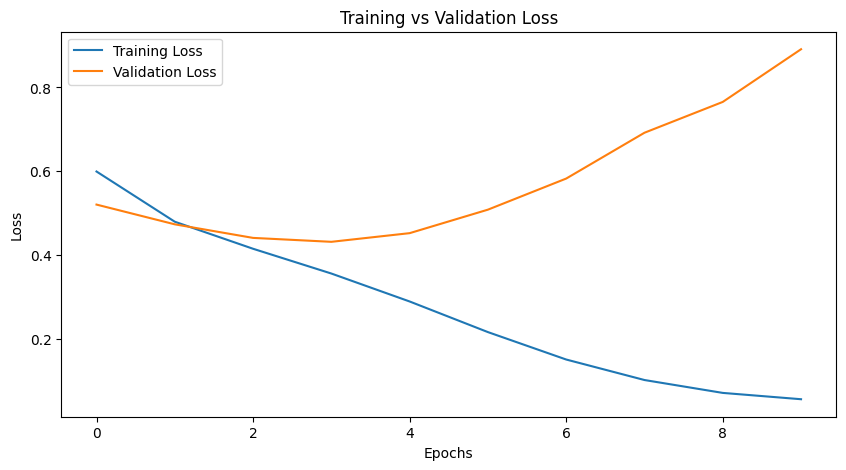

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Convertir etiquetas a one-hot encoding para CNN
y_categorical = to_categorical(y, num_classes=2)

# Definir StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Función para entrenar y mostrar métricas sin Wandb
def train_cnn_model(model_fn):
    fold = 0
    training_losses = []
    validation_losses = []

    # Listas para almacenar las métricas de cada fold
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(train_cnn, y):  # Usar train_cnn en lugar de train_images
        fold += 1
        print("---------------------------------------------")
        print(f"\nTraining Fold {fold}...")

        X_train, X_test = train_cnn[train_index], train_cnn[test_index]  # Usar train_cnn en lugar de train_images
        y_train, y_test = y_categorical[train_index], y_categorical[test_index]

        # Crear el modelo
        model = model_fn()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Entrenar el modelo
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

        # Guardar pérdidas
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        # Hacer predicciones para las métricas
        y_pred = model.predict(X_test)
        y_pred_class = y_pred.argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        # Calcular las métricas
        auc = roc_auc_score(y_true, y_pred[:, 1])
        precision = precision_score(y_true, y_pred_class)
        recall = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)

        # Guardar métricas
        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Mostrar los resultados promedio y desviación estándar
    print(f"\nResults")
    print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
    print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

    # Graficar las pérdidas (loss) de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(training_losses, axis=0), label="Training Loss")
    plt.plot(np.mean(validation_losses, axis=0), label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Entrenar usando el primer modelo CNN
train_cnn_model(create_cnn_model_1)

---------------------------------------------

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 4s 3ms/step - loss: 0.6203 - accuracy: 0.6448 - val_loss: 0.5310 - val_accuracy: 0.7452
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.4768 - accuracy: 0.7719 - val_loss: 0.4297 - val_accuracy: 0.8048
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3979 - accuracy: 0.8197 - val_loss: 0.4348 - val_accuracy: 0.7916
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3480 - accuracy: 0.8468 - val_loss: 0.3665 - val_accuracy: 0.8388
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2956 - accuracy: 0.8719 - val_loss: 0.3589 - val_accuracy: 0.8308
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2529 - accuracy: 0.8934 - val_loss: 0.3431 - val_accuracy: 0.8520
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2104 -

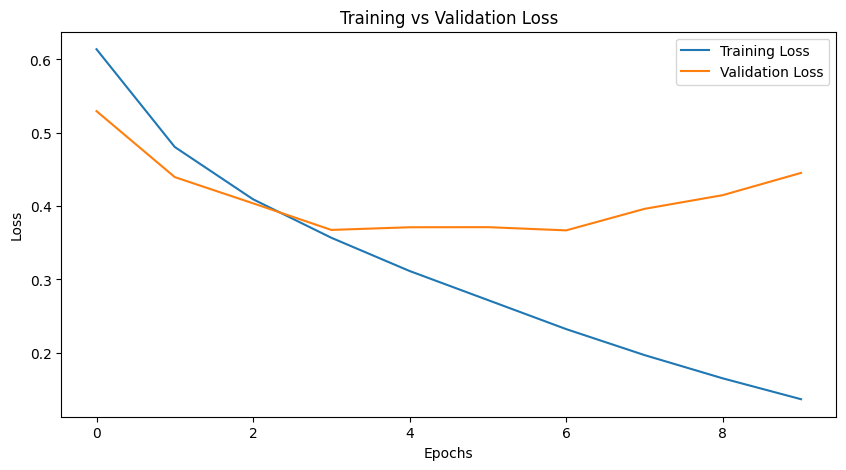

In [21]:
# Entrenar usando el primer modelo CNN
train_cnn_model(create_cnn_model_2)

---------------------------------------------

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 5s 4ms/step - loss: 0.6393 - accuracy: 0.6169 - val_loss: 0.5429 - val_accuracy: 0.7152
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.4943 - accuracy: 0.7620 - val_loss: 0.4468 - val_accuracy: 0.7812
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 0.4172 - accuracy: 0.8104 - val_loss: 0.3885 - val_accuracy: 0.8216
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3524 - accuracy: 0.8428 - val_loss: 0.3757 - val_accuracy: 0.8344
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3090 - accuracy: 0.8663 - val_loss: 0.3816 - val_accuracy: 0.8328
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2662 - accuracy: 0.8857 - val_loss: 0.4133 - val_accuracy: 0.8436
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 0.2224 -

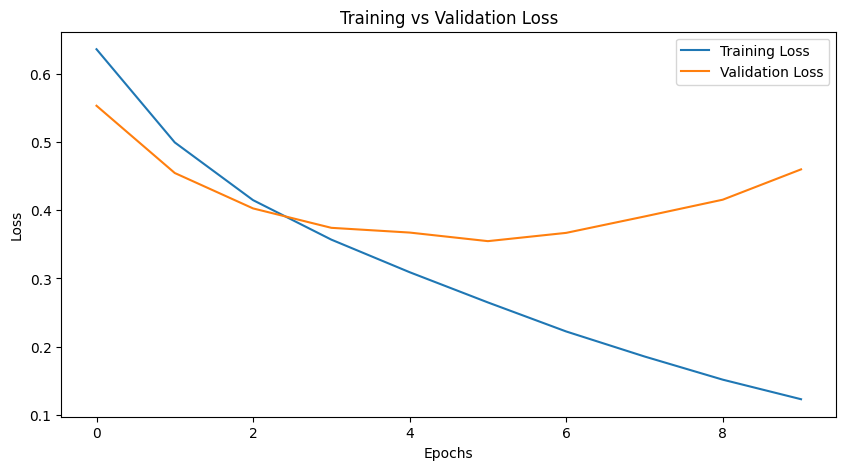

In [22]:
# Entrenar usando el primer modelo CNN
train_cnn_model(create_cnn_model_3)

### Incluyendo Callbacks y Data Augmentation

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Crear las etiquetas (1 para perro, 0 para gato)
y = np.array([1 if 'dog' in img else 0 for img in os.listdir(train_folder)])

# Crear un generador de datos con data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Callback para reducir el learning rate cuando la métrica no mejora
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Arquitectura 1: Modelo básico ajustado para 3 canales (RGB) usando Input
def create_cnn_model_1():
    model = Sequential([
        Input(shape=(64, 64, 3)),  # Definir la entrada explícitamente con Input
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(2, activation='softmax')
    ])
    return model

# Arquitectura 2: Modelo con más capas ajustado para 3 canales (RGB) usando Input
def create_cnn_model_2():
    model = Sequential([
        Input(shape=(64, 64, 3)),  # Definir la entrada explícitamente con Input
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

# Arquitectura 3: Más densa con Dropout ajustado para 3 canales (RGB) usando Input
def create_cnn_model_3():
    model = Sequential([
        Input(shape=(64, 64, 3)),  # Definir la entrada explícitamente con Input
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.6),  # Aumentado el dropout para mayor regularización
        Dense(2, activation='softmax')
    ])
    return model

# Convertir etiquetas a one-hot encoding para CNN
y_categorical = to_categorical(y, num_classes=2)

# Definir StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Función para entrenar y mostrar métricas
def train_cnn_model(model_fn):
    fold = 0
    training_losses = []
    validation_losses = []

    # Listas para almacenar las métricas de cada fold
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(train_cnn, y):
        fold += 1
        print(f"Training Fold {fold}...")

        X_train, X_test = train_cnn[train_index], train_cnn[test_index]
        y_train, y_test = y_categorical[train_index], y_categorical[test_index]

        # Crear el modelo
        model = model_fn()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Aplicar data augmentation solo al conjunto de entrenamiento
        datagen.fit(X_train)
        history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                            validation_data=(X_test, y_test), epochs=10, callbacks=[lr_scheduler])

        # Guardar pérdidas
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        # Hacer predicciones para las métricas
        y_pred = model.predict(X_test)
        y_pred_class = y_pred.argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        # Calcular las métricas
        auc = roc_auc_score(y_true, y_pred[:, 1])
        precision = precision_score(y_true, y_pred_class)
        recall = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)

        # Guardar métricas
        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Mostrar los resultados promedio y desviación estándar
    print(f"\nResults")
    print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
    print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

    # Graficar las pérdidas (loss) de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(training_losses, axis=0), label="Training Loss")
    plt.plot(np.mean(validation_losses, axis=0), label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 19s 25ms/step - loss: 0.8899 - accuracy: 0.6391 - val_loss: 0.7703 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 2/10
704/704 [==============================] - 18s 25ms/step - loss: 0.7235 - accuracy: 0.6863 - val_loss: 0.6814 - val_accuracy: 0.7036 - lr: 0.0010
Epoch 3/10
704/704 [==============================] - 17s 24ms/step - loss: 0.6571 - accuracy: 0.7164 - val_loss: 0.6038 - val_accuracy: 0.7652 - lr: 0.0010
Epoch 4/10
704/704 [==============================] - 17s 24ms/step - loss: 0.6154 - accuracy: 0.7366 - val_loss: 0.6081 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 5/10
704/704 [==============================] - 17s 24ms/step - loss: 0.5988 - accuracy: 0.7491 - val_loss: 0.5696 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 6/10
704/704 [==============================] - 17s 24ms/step - loss: 0.5809 - accuracy: 0.7643 - val_loss: 0.6181 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 7/10
704/704 [===================

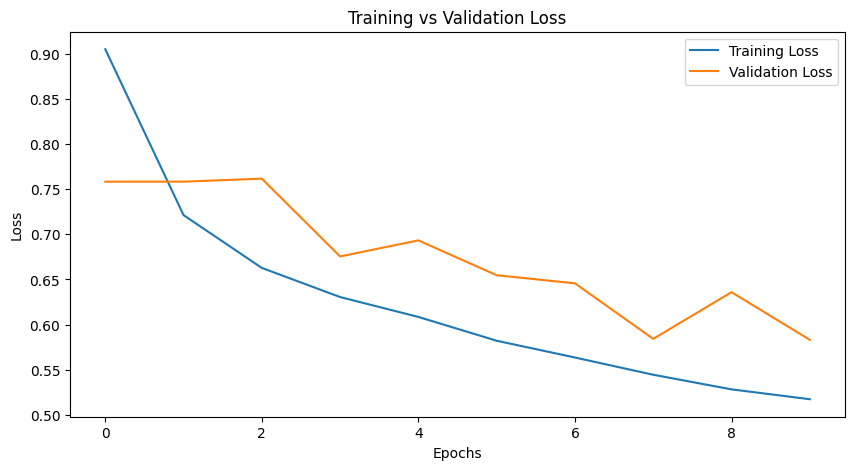

In [27]:
# Entrenar usando el primer modelo CNN con data augmentation
trained_model1 = train_cnn_model(create_cnn_model_1)

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 20s 25ms/step - loss: 1.2080 - accuracy: 0.6269 - val_loss: 0.9962 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 2/10
704/704 [==============================] - 17s 24ms/step - loss: 0.8702 - accuracy: 0.6826 - val_loss: 0.8069 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 3/10
704/704 [==============================] - 17s 24ms/step - loss: 0.7491 - accuracy: 0.7142 - val_loss: 0.7008 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 4/10
704/704 [==============================] - 17s 24ms/step - loss: 0.7133 - accuracy: 0.7400 - val_loss: 1.3939 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 5/10
704/704 [==============================] - 17s 24ms/step - loss: 0.6892 - accuracy: 0.7666 - val_loss: 0.6145 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 6/10
704/704 [==============================] - 17s 24ms/step - loss: 0.6604 - accuracy: 0.7835 - val_loss: 0.6434 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 7/10
704/704 [===================

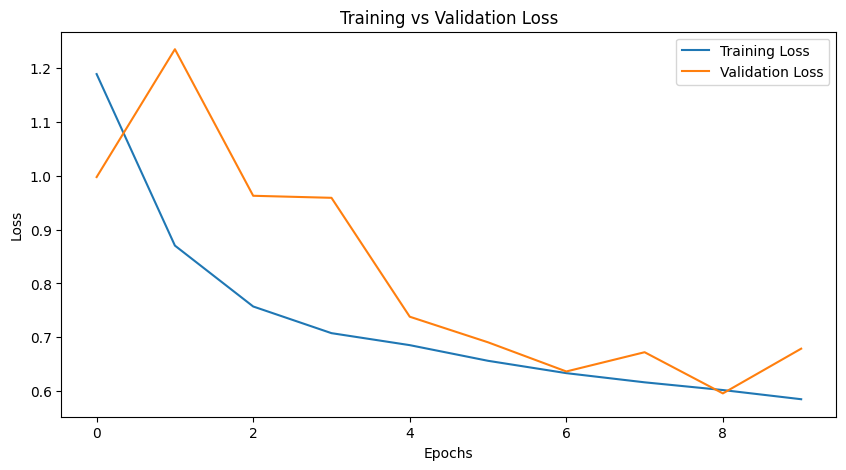

In [28]:
# Entrenar usando el primer modelo CNN con data augmentation
trained_model2 = train_cnn_model(create_cnn_model_2)

Training Fold 1...
Epoch 1/10
704/704 [==============================] - 20s 25ms/step - loss: 1.7380 - accuracy: 0.6039 - val_loss: 1.1241 - val_accuracy: 0.6636 - lr: 0.0010
Epoch 2/10
704/704 [==============================] - 17s 24ms/step - loss: 1.0475 - accuracy: 0.6448 - val_loss: 0.9013 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 3/10
704/704 [==============================] - 17s 25ms/step - loss: 0.9328 - accuracy: 0.6687 - val_loss: 1.1309 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 4/10
704/704 [==============================] - 17s 25ms/step - loss: 0.8259 - accuracy: 0.7115 - val_loss: 0.8353 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 5/10
704/704 [==============================] - 17s 24ms/step - loss: 0.8340 - accuracy: 0.7284 - val_loss: 0.9662 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 6/10
704/704 [==============================] - 17s 24ms/step - loss: 0.7995 - accuracy: 0.7503 - val_loss: 0.7845 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 7/10
704/704 [===================

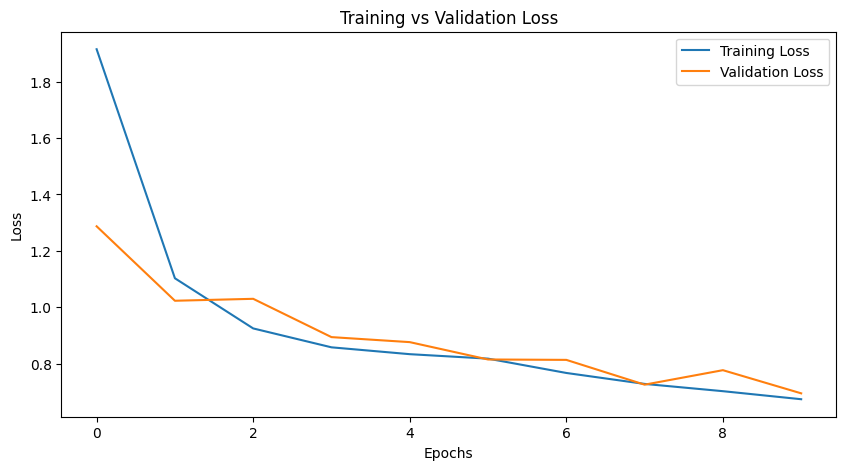

In [29]:
# Entrenar usando el primer modelo CNN con data augmentation
trained_model3 = train_cnn_model(create_cnn_model_3)

In [30]:
# Preprocessed test data (assume `test_cnn` is already preprocessed)
# test_cnn is the equivalent of train_cnn but for your test images.

# Hacer predicciones en el conjunto de test
test_predictions = trained_model3.predict(test_cnn)

# Convertir las predicciones (probabilidades) a etiquetas (0 o 1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Convertir predicciones (0 y 1) a etiquetas "cat" y "dog"
test_pred_labels = ['cat' if pred == 0 else 'dog' for pred in test_pred_labels]

# Imprimir etiquetas predichas para cada imagen de test
for img_name, label in zip(os.listdir(test_folder), test_pred_labels):
    print(f"Image: {img_name} -> Predicted: {label}")


Streaming output truncated to the last 5000 lines.
Image: 610.jpg -> Predicted: dog
Image: 1381.jpg -> Predicted: dog
Image: 708.jpg -> Predicted: dog
Image: 3892.jpg -> Predicted: dog
Image: 8657.jpg -> Predicted: dog
Image: 6025.jpg -> Predicted: dog
Image: 6464.jpg -> Predicted: dog
Image: 4513.jpg -> Predicted: dog
Image: 422.jpg -> Predicted: dog
Image: 11645.jpg -> Predicted: dog
Image: 3941.jpg -> Predicted: dog
Image: 10575.jpg -> Predicted: cat
Image: 2969.jpg -> Predicted: dog
Image: 4445.jpg -> Predicted: cat
Image: 1580.jpg -> Predicted: dog
Image: 9649.jpg -> Predicted: dog
Image: 9957.jpg -> Predicted: cat
Image: 9108.jpg -> Predicted: dog
Image: 12480.jpg -> Predicted: cat
Image: 10316.jpg -> Predicted: cat
Image: 4446.jpg -> Predicted: cat
Image: 10270.jpg -> Predicted: cat
Image: 5743.jpg -> Predicted: cat
Image: 1142.jpg -> Predicted: cat
Image: 481.jpg -> Predicted: dog
Image: 4308.jpg -> Predicted: cat
Image: 6276.jpg -> Predicted: dog
Image: 5910.jpg -> Predicted: 

## +1

(mejorado)


Training Fold 1...
Epoch 1/10
704/704 [==============================] - 6s 5ms/step - loss: 0.6824 - accuracy: 0.6453 - val_loss: 0.6691 - val_accuracy: 0.5884
Epoch 2/10
704/704 [==============================] - 3s 4ms/step - loss: 0.4905 - accuracy: 0.7679 - val_loss: 0.4942 - val_accuracy: 0.7732
Epoch 3/10
704/704 [==============================] - 3s 4ms/step - loss: 0.3907 - accuracy: 0.8252 - val_loss: 0.4512 - val_accuracy: 0.7876
Epoch 4/10
704/704 [==============================] - 3s 4ms/step - loss: 0.3321 - accuracy: 0.8565 - val_loss: 0.4624 - val_accuracy: 0.7632
Epoch 5/10
704/704 [==============================] - 3s 4ms/step - loss: 0.2900 - accuracy: 0.8804 - val_loss: 0.3603 - val_accuracy: 0.8528
Epoch 6/10
704/704 [==============================] - 3s 4ms/step - loss: 0.2456 - accuracy: 0.8985 - val_loss: 0.3197 - val_accuracy: 0.8728
Epoch 7/10
704/704 [==============================] - 3s 4ms/step - loss: 0.2128 - accuracy: 0.9149 - val_loss: 0.3499 - val_acc

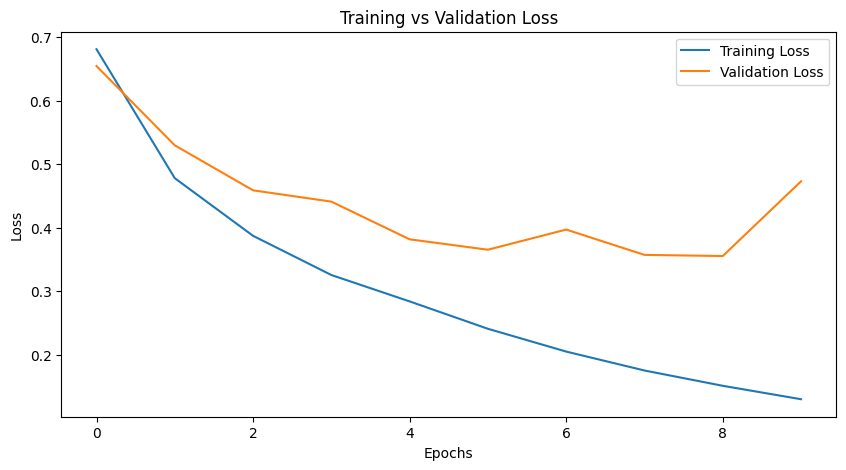

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Deep CNN Architecture
def create_deep_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),

        Dense(256, activation='relu'),
        Dropout(0.5),

        Dense(2, activation='softmax')
    ])

    return model

# Function to train and evaluate the deep CNN model
def train_deep_cnn_model():
    skf = StratifiedKFold(n_splits=10)
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Para guardar las pérdidas de entrenamiento y validación
    training_losses = []
    validation_losses = []

    fold = 0
    for train_index, test_index in skf.split(train_cnn, y):
        fold += 1
        print(f"\nTraining Fold {fold}...")

        X_train, X_test = train_cnn[train_index], train_cnn[test_index]
        y_train, y_test = y_categorical[train_index], y_categorical[test_index]

        model = create_deep_cnn_model()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

        # Almacenar las pérdidas de entrenamiento y validación para cada época
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        y_pred = model.predict(X_test)
        y_pred_class = y_pred.argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        auc = roc_auc_score(y_true, y_pred[:, 1])
        precision = precision_score(y_true, y_pred_class)
        recall = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Mostrar resultados promedio
    print("\nResults")
    print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
    print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

    # Graficar pérdidas de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(training_losses, axis=0), label="Training Loss")
    plt.plot(np.mean(validation_losses, axis=0), label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Train the deep CNN model
train_deep_cnn_model()

### with adjustments


Training Fold 1...
Epoch 1/30
704/704 [==============================] - 8s 6ms/step - loss: 0.9088 - accuracy: 0.6115 - val_loss: 0.7328 - val_accuracy: 0.6812 - lr: 1.0000e-04
Epoch 2/30
704/704 [==============================] - 4s 6ms/step - loss: 0.6876 - accuracy: 0.7328 - val_loss: 0.6094 - val_accuracy: 0.7992 - lr: 1.0000e-04
Epoch 3/30
704/704 [==============================] - 4s 5ms/step - loss: 0.6038 - accuracy: 0.7833 - val_loss: 0.5897 - val_accuracy: 0.7880 - lr: 1.0000e-04
Epoch 4/30
704/704 [==============================] - 4s 5ms/step - loss: 0.5364 - accuracy: 0.8208 - val_loss: 0.5425 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 5/30
704/704 [==============================] - 4s 5ms/step - loss: 0.4824 - accuracy: 0.8539 - val_loss: 0.5088 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 6/30
704/704 [==============================] - 4s 5ms/step - loss: 0.4203 - accuracy: 0.8786 - val_loss: 0.6113 - val_accuracy: 0.7968 - lr: 1.0000e-04
Epoch 7/30
704/704 [======

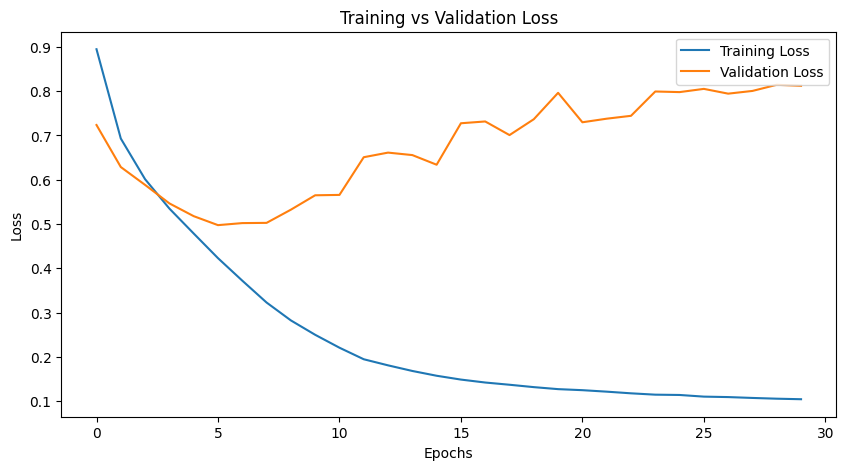

In [31]:
#x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Deep CNN Architecture with adjustments
def create_deep_cnn_model():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),  # Replaces Flatten to reduce the number of parameters

        Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.6),  # Increased dropout for regularization

        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),

        Dense(2, activation='softmax')
    ])

    return model

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Function to train and evaluate the deep CNN model
def train_deep_cnn_model():
    skf = StratifiedKFold(n_splits=10)
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Para guardar las pérdidas de entrenamiento y validación
    training_losses = []
    validation_losses = []

    fold = 0
    for train_index, test_index in skf.split(train_cnn, y):
        fold += 1
        print(f"\nTraining Fold {fold}...")

        X_train, X_test = train_cnn[train_index], train_cnn[test_index]
        y_train, y_test = y_categorical[train_index], y_categorical[test_index]

        model = create_deep_cnn_model()
        model.compile(optimizer=AdamW(learning_rate=1e-4),  # Changed optimizer to AdamW
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # Added learning rate scheduler
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=30, batch_size=32, callbacks=[lr_callback])

        # Almacenar las pérdidas de entrenamiento y validación para cada época
        training_losses.append(history.history['loss'])
        validation_losses.append(history.history['val_loss'])

        y_pred = model.predict(X_test)
        y_pred_class = y_pred.argmax(axis=1)
        y_true = y_test.argmax(axis=1)

        auc = roc_auc_score(y_true, y_pred[:, 1])
        precision = precision_score(y_true, y_pred_class)
        recall = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)

        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Mostrar resultados promedio
    print("\nResults")
    print(f"AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
    print(f"Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
    print(f"Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    print(f"F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

    # Graficar pérdidas de entrenamiento y validación
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(training_losses, axis=0), label="Training Loss")
    plt.plot(np.mean(validation_losses, axis=0), label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Optionally add pretrained ResNet model for transfer learning and fine-tuning
def create_resnet_finetune_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
    base_model.trainable = False  # Freeze the pretrained layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    return model

# Train the deep CNN model
train_deep_cnn_model()